# Exercise 13 - Applying ESNs to the Lorenz System

- In the lecture, we trained an ESN to reproduce the dynamics of the Lorenz system, correctly predicting the Lorenz trajectory up to ~10 Lyapunov times. After this time, the predicted trajectory deviates from the actual Lorenz trajectory, which is expected since small errors grow exponentially due to the chaotic dynamics of the Lorenz system. 


- Do the long-term dynamics of the ESN still constitute a valid Lorenz trajectory? Investigate this question by:
    1. Plotting the attractor of the ESN for a long integration and comparing it qualitatively with the true Lorenz attractor.
    2. Compute the maximum Lyapunov exponent of the ESN dynamics and compare it to the maximum Lyapunov exponent of the Lorenz system.
    

- Bonus: In the lecture, we performed a grid-search on the ESN hyperparameters and kept the model with the lowest error on the validation set. However, because the reservoir is generated randomly, there is some variance in the performance of an ESN for a given set of hyperparameters, meaning that the optimal hyperparameters chosen by cross-validation may not be detereministic. Extend the cross-validation procedure to generate and fit multiple ESNs for each combination of hyperparameters, keeping only the best one. Does this improve the prediction horizon of the ESN?

In [1]:
using DynamicalSystems, ReservoirComputing, Plots, Printf

In [2]:
# Helper functions from the lecture

"""
    train_val_test_split(data; val_seconds, test_seconds, Δt = 0.1)

Split the given data into training, validation, and test sets.
"""
function train_val_test_split(data; val_seconds, test_seconds, Δt = 0.1)
    N = size(data, 2)
    N_val = round(Int, val_seconds / Δt)
    N_test = round(Int, test_seconds / Δt)
    
    ind1 = N - N_test - N_val
    ind2 = N - N_test
    
    train_data = data[:, 1:ind1]
    val_data = data[:, ind1+1:ind2]
    test_data = data[:, ind2+1:end]
    
    return train_data, val_data, test_data
end


"""
    generate_esn(input_signal, reservoir_size = 1000, spectral_radius = 1.0, sparsity = 0.1, input_scale = 0.1)

Generate an Echo State Network consisting of the reservoir weights W and the input weights Wᵢₙ.
"""
function generate_esn(input_signal, reservoir_size = 1000, spectral_radius = 1.0, sparsity = 0.1, input_scale = 0.1)
    W = RandSparseReservoir(reservoir_size, radius = spectral_radius, sparsity = sparsity)
    Wᵢₙ = WeightedLayer(scaling = input_scale)
    return ESN(input_signal, reservoir = W, input_layer = Wᵢₙ)
end


"""
    train_esn!(esn, y, ridge_param)

Given an Echo State Network, train it on the target sequence y_target and return the optimised output weights Wₒᵤₜ.
"""
function train_esn!(esn, y_target, ridge_param)
    training_method = StandardRidge(ridge_param)
    return train(esn, y_target, training_method)
end


"""
    cross_validate_esn(train_data, val_data, param_grid)

Do a grid search on the given param_grid to find the optimal hyperparameters.
"""
function cross_validate_esn(train_data, val_data, param_grid; iters = 1)
    best_loss = Inf
    best_params = nothing
    best_esn = nothing

    # We want to predict one step ahead, so the input signal is equal to the target signal from the previous step
    u_train = train_data[:, 1:end-1]
    y_train = train_data[:, 2:end]
        
    for hyperparams in param_grid
        # Unpack the hyperparams struct
        (;reservoir_size, spectral_radius, sparsity, input_scale, ridge_param) = hyperparams

        for _ in 1:iters
            # Generate and train an ESN
            esn = generate_esn(u_train, reservoir_size, spectral_radius, sparsity, input_scale)
            Wₒᵤₜ = train_esn!(esn, y_train, ridge_param)

            # Evaluate the loss on the validation set
            steps_to_predict = size(val_data, 2)
            prediction = esn(Generative(steps_to_predict), Wₒᵤₜ)
            loss = sum(abs2, prediction - val_data)

            # Keep track of the best hyperparameter values
            if loss < best_loss
                best_loss = loss
                best_params = hyperparams
                best_esn = esn
                println(hyperparams)
                @printf "Validation loss = %.1e\n" best_loss
            end
        end
    end
    
    # Retrain the model using the optimal hyperparameters on both the training and validation data
    # This is necessary because we don't want errors incurred during validation to affect the test error
    data = hcat(train_data, val_data)
    u = data[:, 1:end-1]
    y = data[:, 2:end]
    esn = ESN(u, reservoir = best_esn.reservoir_matrix, input_layer = best_esn.input_matrix)
    Wₒᵤₜ = train_esn!(esn, y, best_params.ridge_param)
    
    return esn, Wₒᵤₜ
end


"""
    plot_prediction(esn, Wₒᵤₜ, test_data, λ_max)

Given an Echo State Network, plot its predictions versus the given test set.
"""
function plot_prediction(esn, Wₒᵤₜ, test_data, λ_max)
    steps_to_predict = size(test_data, 2)
    prediction = esn(Generative(steps_to_predict), Wₒᵤₜ)
    
    label = ["actual" "predicted"]
    times = Δt * collect(0:steps_to_predict)[1:end-1] / λ_max

    p1 = plot(times, [test_data[1, :], prediction[1, :]], label = label, ylabel = "x(t)")
    p2 = plot(times, [test_data[2, :], prediction[2, :]], label = label, ylabel = "y(t)")
    p3 = plot(times, [test_data[3, :], prediction[3, :]], label = label, ylabel = "z(t)", xlabel = "t * λ_max")
    plot(p1, p2, p3, layout = (3, 1), size = (800, 600))
end


"""
Hyperparameters for an Echo State Network.
"""
struct ESNHyperparams
    reservoir_size
    spectral_radius
    sparsity
    input_scale
    ridge_param
end

ESNHyperparams

In [3]:
# Set up the Lorenz system
ds = Systems.lorenz63()

# Compute the maximum Lyapunov exponent of the system (we will use this to benchmark the model predictions later)
λ_max = lyapunov(ds, 100, Ttr = 100)

# Integrate the system
T = 200.0
Δt = 0.1
Ttr = 100.0

tr = trajectory(ds, T, Δt = Δt, Ttr = Ttr)
x, y, z = columns(tr)

# Put the data in the matrix format (n_features, n_samples) required by ReservoirComputing.jl 
data = reduce(vcat, [x, y, z]')

3×2001 Matrix{Float64}:
  5.22753  10.7286  15.3066   9.28373   …  -6.19352  -1.21208   0.420035
  9.14907  17.4786  14.9175   0.533337      1.28217   1.57029   1.34964
 12.8547   19.4383  36.6727  36.3105       32.6602   24.5493   18.7748

## Cross-Validation

- We do the bonus part of the exercise first and experiment with alternative cross-validation techniques.


- In particular, we should point out two important modifications to the method `cross_validate_esn` compared to the one we used in the lecture:
    1. We now reuse the reservoir connections matrix $\mathbf W$ and the input matrix $\mathbf W^{\mathrm{in}}$ of the best model. In the lecture, we simply stored the hyperparameters of the best model and used them to generate a new ESN, and in turn a new $\mathbf W$ and the input matrix $\mathbf W^{\mathrm{in}}$. However, due to the randomness in the ESN generation, it's possible that this new reservoir would turn out to be suboptimal.
    2. For each combination of hyperparameters, we now have the option of generating and evaluating multiple ESNs, to account for the possibility of individual ESNs which perform poorly. This is controlled by the `iters` keyword argument of `cross_validate_esn`.
    
   
- To keep the runtime to a minimum, we will only optimise the spectral radius of the reservoir, but feel free to experiment with other hyperparameter values.

In [4]:
# Set up the hyperparameter grid-search
param_grid = []

reservoir_sizes = [1024]
spectral_radii = [0.6, 0.8, 1.0, 1.2]
sparsities = [0.05]
input_scales = [0.1]
ridge_values = [0.0]

# Take the Cartesian product of the possible values
for params in Iterators.product(reservoir_sizes, spectral_radii, sparsities, input_scales, ridge_values)
    push!(param_grid, ESNHyperparams(params...))
end

println(length(param_grid), " hyperparameter combinations.")

4 hyperparameter combinations.


ESNHyperparams(1024, 0.6, 0.05, 0.1, 0.0)
Validation loss = 1.9e+09
ESNHyperparams(1024, 0.6, 0.05, 0.1, 0.0)
Validation loss = 7.2e+07
ESNHyperparams(1024, 0.6, 0.05, 0.1, 0.0)
Validation loss = 6.5e+06
ESNHyperparams(1024, 0.8, 0.05, 0.1, 0.0)
Validation loss = 2.7e+04
ESNHyperparams(1024, 0.8, 0.05, 0.1, 0.0)
Validation loss = 2.3e+04
175.189716 seconds (37.04 M allocations: 3.331 GiB, 0.61% gc time, 11.77% compilation time)


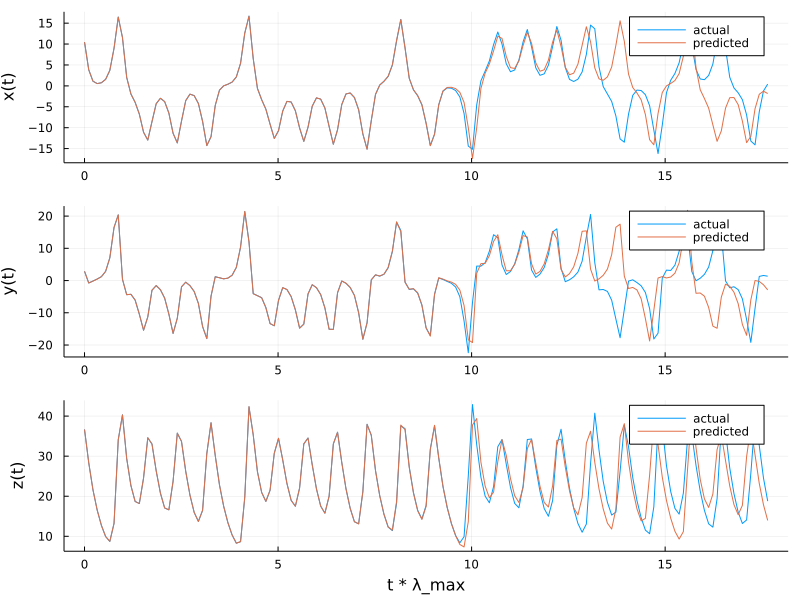

In [5]:
train_data, val_data, test_data = train_val_test_split(data, val_seconds = 15 / λ_max, test_seconds = 15 / λ_max);
@time esn, Wₒᵤₜ = cross_validate_esn(train_data, val_data, param_grid, iters = 5)
plot_prediction(esn, Wₒᵤₜ, test_data, λ_max)

- Based on our experiments, it is difficult to reliably obtain a meaningful prediction beyond ~10 Lyapunov times (which is still very good), although we did observe occasional models capable of predicting up to 13-14 Lyapunov times. Once again, feel free to experiment.

## Plotting the Lorenz Attractor of the ESN

In [6]:
# Generate a trajectory from the trained ESN
steps_to_predict = length(tr)
predicted_trajectory = esn(Generative(steps_to_predict), Wₒᵤₜ)
predicted_trajectory = Dataset(predicted_trajectory')  # Put the data in a Dataset object for DynamicalSystems.jl 

3-dimensional Dataset{Float64} with 2001 points
  10.468       2.86612   36.6561
   3.85358    -0.768673  28.3581
   1.12281    -0.163565  21.612
   0.548393    0.462871  16.5621
   0.741969    1.1978    12.7296
   1.5549      2.83743    9.94587
   3.70829     7.04369    8.72137
   8.99498    16.4738    13.2236
  16.4534     20.3706    34.1082
  11.5491      0.381545  40.3027
   2.01914    -4.39893   29.4086
  -1.93311    -4.25908   22.6598
  -3.93524    -6.05151   18.6922
   ⋮                     
  -5.757      -8.10304   19.1594
  -8.98801   -12.8958    21.5769
 -12.2895    -13.9062    30.0975
 -10.839      -6.7381    34.1703
  -6.39697    -2.62521   29.3179
  -4.04821    -3.06618   23.5949
  -4.15989    -5.27103   19.4875
  -6.24987    -9.35621   18.2119
 -10.2036    -14.5805    22.8764
 -12.9736    -12.854     33.019
  -9.61909    -4.28941   33.9121
  -5.00235    -1.75864   27.5674

- Note: It doesn't matter that this trajectory has different initial conditions from the ground truth trajectory we generated earlier, as we are only interested in the qualitative shape of the attractor.

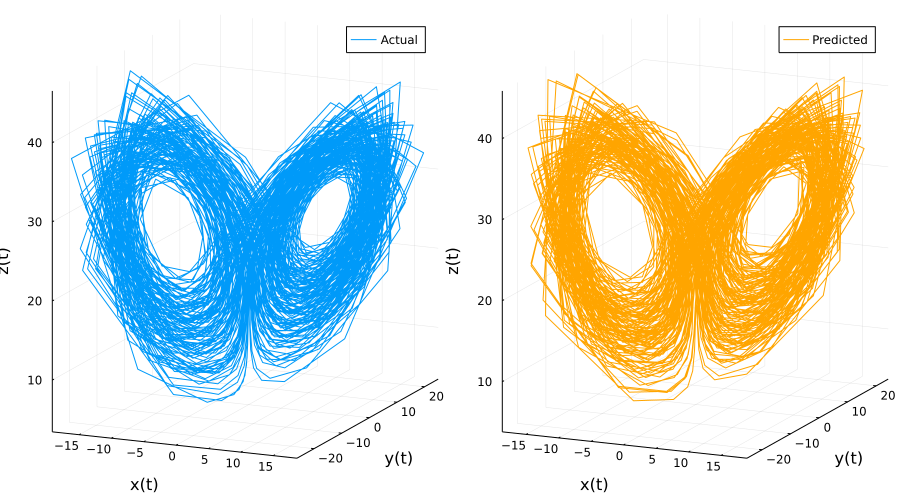

In [7]:
# Compare the Lorenz attractor of the predicted trajectory to the actual trajectory we computed earlier
p1 = plot(tr[:, 1], tr[:, 2], tr[:, 3], xlabel = "x(t)", ylabel = "y(t)", zlabel = "z(t)", label = "Actual")
p2 = plot(predicted_trajectory[:, 1], predicted_trajectory[:, 2], predicted_trajectory[:, 3], xlabel = "x(t)", ylabel = "y(t)", zlabel = "z(t)", label = "Predicted", color = :orange)
plot(p1, p2, layout = (1, 2), size = (900, 500))

- While the timestep is relatively large, rendering the plot not very smooth, the predicted attractor looks qualitatively reasonable, albeit not perfect.

## Estimating the Maximum Lyapunov Exponent from the Trained ESN

- For simplicity, we will reuse the method from exercise 6 for estimating Lyapunov exponents from data.

In [8]:
using CairoMakie

"""Helper function to compute the Lyapunov exponent and plot k x Δt versus E(k) - E(0)."""
function estimate_lyapunov(data, ks, Δt)    
    E = lyapunov_from_data(data, ks)   # Returns [E(k) for k ∈ ks]
    t = ks .* Δt
    (ind1, ind2), λ = linear_region(t, E)
    
    println("Identified linear region between t = ", t[ind1], " and t = ", t[ind2])
    println("Estimated Lyapunov exponent λ = ", round(λ, digits = 3))
    
    # Plotting
    xlim = maximum(ks .* Δt)
    ylim = maximum(E .- E[1])
    xticks = 0:ks.step:xlim
    yticks=0:1:ylim
    fig = CairoMakie.Figure(figsize=(500,500))
    ax = CairoMakie.Axis(fig[1, 1]; xlabel="k x Δt", ylabel="E(k) - E(0)", xticks, yticks)
    CairoMakie.lines!(ax, ks .* Δt, E .- E[1], label = "λ=$(round(λ, digits = 3))")
    CairoMakie.axislegend(ax, position = :rb)
    fig
end

estimate_lyapunov

Identified linear region between t = 0.9 and t = 3.4
Estimated Lyapunov exponent λ = 0.857


┌ Warning: Found linear region spans less than a 3rd of the available x-axis and might imply inaccurate slope or insufficient data. Recommended: plot `x` vs `y`.
└ @ ChaosTools /home/alistair/.julia/packages/ChaosTools/PHPDF/src/dimensions/linear_regions.jl:143


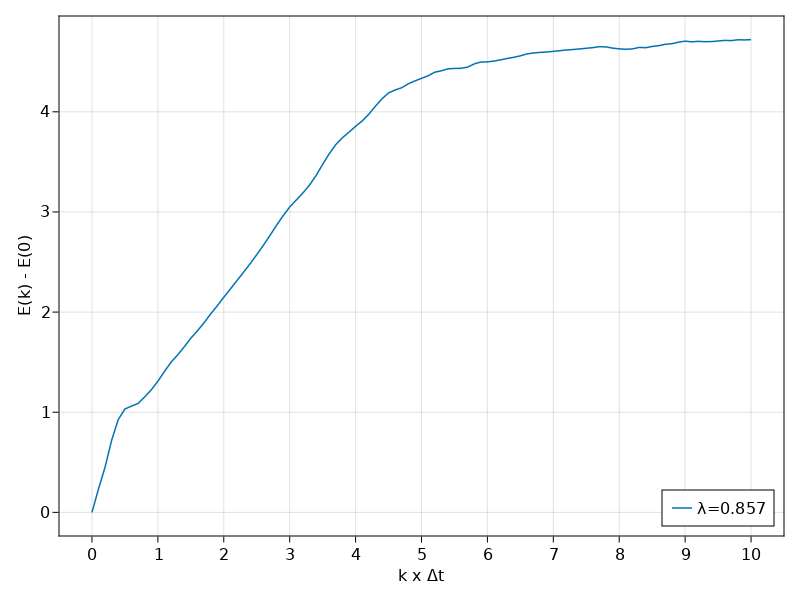

In [9]:
# Generate a long trajectory from the trained ESN
steps_to_predict = 10000
predicted_trajectory = esn(Generative(steps_to_predict), Wₒᵤₜ)
predicted_trajectory = Dataset(predicted_trajectory')  # Put the data in a Dataset object for DynamicalSystems.jl 

# Estimate the Lyapunov exponent
ks = 0:1:100
Δt = 0.1
estimate_lyapunov(predicted_trajectory, ks, Δt)

- Compared to the true Lyapunov exponent $\lambda_{\mathrm{max}} \approx 0.92$, this isn't bad at all. With a more robust hyperparameter search perhaps we could do even better.